<a href="https://colab.research.google.com/github/shv-om/alohomora-execute22/blob/main/Notebook/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk
nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import re
import sys

import pandas as pd
import tweepy as tw

  
import os
import string
import sys
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob


In [ ]:
dir = 'twitter_extract'
try:
  DIR = os.mkdir(dir)
except:
  pass

In [ ]:
consumer_key = "dxfKGBhBzI3I5rckBQDMkfetx";
consumer_secret = "z6TRjHNNGnLI9L26RMcblxjoWZ11h7c9jC0Ulkxry546AOYQUC";
access_token = "1299382645755838464-lVviwhOlr2nhsuE8MtvgohD16rQ6Hi";
access_token_secret = "Oc1CVdgU6wkJyQY1O65pRvpmL5cPAGnjcXBhOzXPBUK4U";

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

print("please select what kind of extract you want:")
print("enter 1 for hashtag related extract")
print("enter 2 for user related extract")
user_select = input()

please select what kind of extract you want:
enter 1 for hashtag related extract
enter 2 for user related extract
1


In [ ]:
def extractTwt(search_words, twtCount=300):
    date_since = "2022-05-28"
    z = twtCount
    new_search = search_words + " -filter:retweets"
    tweets = tw.Cursor(api.search,
                       q=new_search,
                       lang="en",
                       since=date_since, tweet_mode='extended').items(z)
    users_info = [[tweet.user.id, tweet.user.created_at,
                   tweet.user.screen_name, tweet.user.location, tweet.full_text.replace('\n', ' ').encode('utf-8'),
                   tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count,
                   [e['text'] for e in tweet._json['entities']['hashtags']]
                   ] for tweet in tweets]

    tweet_text = pd.DataFrame(data=users_info,
                              columns=['id', 'created_at', 'User_name', "location", 'tweet_details',
                                       'favorite', 'retweet', 'followers', 'All_hashtags'])
    fname = '_'.join(re.findall(r"#(\w+)", search_words))
    filePath = dir+'/'+search_words+'.csv'

    tweet_text.to_csv(filePath, index=False)
    return filePath


In [ ]:
#""" #OFF for output
def initPrp(filePath,hmc=False):
  try:
      #in_fname = input("Please enter the filename without extension:")
      in_fname = input("Please enter the complete filename:")
      #df_tid = pd.read_csv('C:\Twitter_extract\%s.csv' % (in_fname))
      filePath = dir+'/'+in_fname
      df_tid = pd.read_csv(filePath)

     if not hmc:
        hmc = int(input("How many records you want to see:"))

      df_tid['tweet_details'] = df_tid['tweet_details'].replace("b'", '', regex=True)
      df_tid['tweet_details'] = df_tid['tweet_details'].replace('b"', '', regex=True)

  except:
      print("Incorrect file name")
      return False
  finally:
      return df_tid

IndentationError: ignored

In [ ]:
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [ ]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

In [ ]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text


In [ ]:
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

In [ ]:
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text


In [ ]:
savedIn = extractTwt('sport', 200)
df_tid = initPrp(savedIn, 100)

df_tid['tweet_details_punc_removed'] = df_tid['tweet_details'].apply(lambda x: remove_punct(x))

df_tid['Tweet_tokenized'] = df_tid['tweet_details_punc_removed'].apply(lambda x: tokenization(x.lower()))

stopword = nltk.corpus.stopwords.words('english')

df_tid['Tweet_nonstop'] = df_tid['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))

ps = nltk.PorterStemmer()

df_tid['Tweet_stemmed'] = df_tid['Tweet_nonstop'].apply(lambda x: stemming(x))

wn = nltk.WordNetLemmatizer()



df_tid['Tweet_lemmatized'] = df_tid['Tweet_nonstop'].apply(lambda x: lemmatizer(x))

df_tid_tokenizer = df_tid
df_tid_stich = df_tid_tokenizer['Tweet_lemmatized']

for i in range(len(df_tid_stich)):
    df_tid_stich[i] = ' '.join(df_tid_stich.loc[i])

df_tid_tokenizer['Tweet_lemma'] = df_tid_stich





del df_tid_tokenizer['Tweet_lemmatized']
df_tid_tokenizer.head(hmc)






df_tid_polarity = df_tid_tokenizer.copy(deep=False)

for i in range(len(df_tid_polarity)):
    analysis = TextBlob(df_tid_polarity.loc[i, 'Tweet_lemma'])
    df_tid_polarity.loc[i, 'Tweet_polarity'] = analysis.sentiment[0]
    df_tid_polarity.loc[i, 'Tweet_subjectivity'] = analysis.sentiment[1]
    if analysis.sentiment[0] > 0:
        df_tid_polarity.loc[i, 'Polarity_indication'] = 'Positive'
    elif analysis.sentiment[0] < 0:
        df_tid_polarity.loc[i, 'Polarity_indication'] = 'Negative'
    else:
        df_tid_polarity.loc[i, 'Polarity_indication'] = 'Neutral'

df_tid_polarity.head()

tweet_weight = []
for i in range(0, z):
    follower_length: int = len(str(df_tid_polarity.followers[i]))
    tweet_weight.append(follower_length * df_tid_polarity.Tweet_polarity[i])

df_tid_polarity["Weight (Follower Count)"] = tweet_weight

tweet_retweet = []
for i in range(0, z):
    retweet_length: int = len(str(df_tid_polarity.retweet[i]))
    tweet_retweet.append(retweet_length * df_tid_polarity.Tweet_polarity[i])

df_tid_polarity["Weight (No. of Retweets"] = retweet_length

if user_select == 1:
    final_df_tid_polarity = df_tid_polarity.sort_values(by=['Weight (Follower Count)'], ascending=False)
    final_df_tid_polarity.head()
    final_df_tid_polarity.to_csv('final_df_tid_polarity.csv', encoding='utf-8') #OFF

elif user_select == 2:
    final_df_tid_polarity = df_tid_polarity.sort_values(by=['Weight (No. of Retweets1'
                                                            ''], ascending=False)
    final_df_tid_polarity.head()
    final_df_tid_polarity.to_csv('final_df_tid_polarity.csv', encoding='utf-8')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

1. For Histogram details
2. For All tweets Cloudword
3. For negative tweets Cloudword
4. For positive tweets Cloudword
5. For neutral tweets Cloudword
1
Please enter y if you want to save file else n
y
Enter image name without extension:i1


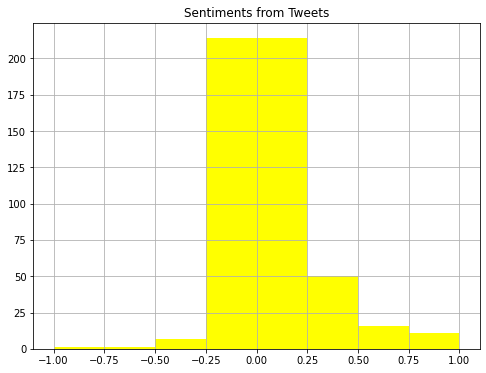

In [ ]:
print("1. For Histogram details")
print("2. For All tweets Cloudword")
print("3. For negative tweets Cloudword")
print("4. For positive tweets Cloudword")
print("5. For neutral tweets Cloudword")
in_val = input()
print("Please enter y if you want to save file else n")
image_save_choice = input()

if image_save_choice == 'y':
    image_fname = input("Enter image name without extension:")
else:
    print("Only image view")

if in_val == "1":
    fig, ax = plt.subplots(figsize=(8, 6))
    df_tid_polarity['Tweet_polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
                                           ax=ax,
                                           color="yellow")

    plt.title("Sentiments from Tweets")
    if image_save_choice == 'y':
        plt.savefig('C:\Twitter_extract\%s.jpg' % (image_fname), dpi=300)
    else:
        plt.show()

elif in_val == "2":
    all_words = ' '.join([text for text in df_tid_polarity['tweet_details_punc_removed']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    if image_save_choice == 'y':
        plt.savefig('C:\Twitter_extract\%s.jpg' % (image_fname), dpi=300)
    else:
        plt.show()

elif in_val == "3":
    normal_words = ' '.join([text for text in df_tid_polarity['Tweet_lemma'][df_tid_polarity['Tweet_polarity'] < 0]])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    if image_save_choice == 'y':
        plt.savefig('C:\Twitter_extract\%s.jpg' % (image_fname), dpi=300)
    else:
        plt.show()

elif in_val == "4":
    normal_words = ' '.join([text for text in df_tid_polarity['Tweet_lemma'][df_tid_polarity['Tweet_polarity'] > 0]])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    if image_save_choice == 'y':
        plt.savefig('C:\Twitter_extract\%s.jpg' % (image_fname), dpi=300)
    else:
        plt.show()

elif in_val == "5":
    normal_words = ' '.join([text for text in df_tid_polarity['Tweet_lemma'][df_tid_polarity['Tweet_polarity'] == 0]])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    if image_save_choice == 'y':
        plt.savefig('C:\Twitter_extract\%s.jpg' % (image_fname), dpi=300)
    else:
        plt.show()

else:
    print("Wrong input")
    

In [ ]:
from nltk import bigrams
import itertools
import collections



In [ ]:
print("Please enter the number of common words you want to see")
in_val_cw = int(input())

print("1. for Bigram detalis")
print("2. for word count detalis")
print("3. for word count plot")
in_val = input()

if in_val == "1":
    terms_bigram = [list(bigrams(tweet)) for tweet in df_tid_tokenizer['Tweet_nonstop']]

    bigrams = list(itertools.chain(*terms_bigram))

    bigram_counts = collections.Counter(bigrams)

    bigram_counts.most_common(in_val_cw)

    bigram_df = pd.DataFrame(bigram_counts.most_common(in_val_cw),
                             columns=['bigram', 'count'])

    #print(bigram_df.head(in_val_cw))
    bigram_df.to_csv('bigram_df.csv', index=False)

elif in_val == "2":
    words_in_tweet = [tweet.lower().split() for tweet in df_tid_tokenizer['Tweet_lemma']]

    all_words_t = list(itertools.chain(*words_in_tweet))

    counts_of_words = collections.Counter(all_words_t)

    cow_tweets = pd.DataFrame(counts_of_words.most_common(in_val_cw),
                              columns=['words', 'count'])
    #print(cow_tweets.head(in_val_cw))

elif in_val == "3":
    print("Please enter y if you want to save file for word count plot else n")
    word_save_choice = input()

    words_in_tweet_p = [tweet.lower().split() for tweet in df_tid_tokenizer['Tweet_lemma']]

    all_words_t_p = list(itertools.chain(*words_in_tweet_p))

    counts_of_words_p = collections.Counter(all_words_t_p)

    cow_tweets_p = pd.DataFrame(counts_of_words_p.most_common(in_val_cw),
                                columns=['words', 'count'])

    if word_save_choice == 'y':
        image_fname = input("Enter image name without extension:")
    else:
        print("Only image view")

    fig, ax = plt.subplots(figsize=(8, 8))

    cow_tweets_p.sort_values(by='count').plot.barh(x='words',
                                                   y='count',
                                                   ax=ax,
                                                   color="purple")

    ax.set_title("Common Words Found in Tweets (Including All Words)")

    if word_save_choice == 'y':
        plt.savefig('C:\Twitter_extract\%s.jpg' % (image_fname), dpi=300)
    else:
        plt.show()
else:
    print("Wrong choice entered")









Please enter the number of common words you want to see
10
1. for Bigram detalis
2. for word count detalis
3. for word count plot
1


TypeError: ignored

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
df_tid_formvector = df_tid_tokenizer.copy(deep=False)

vectorizer = CountVectorizer()
for i in range(len(df_tid_tokenizer)):
    v_text = df_tid_formvector.loc[i, 'Tweet_stemmed']
    vectorizer.fit(v_text)
    text = list((vectorizer.vocabulary_).items())
    df_tid_formvector.loc[i, 'Tweet_vcetor_list'] = str(text)
    vector = vectorizer.transform(v_text)
    print(vector.shape)
    print(type(vector))
    print(vector.toarray())

Streaming output truncated to the last 5000 lines.
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(32, 30)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
vector_presentation_list = []

for i in range(len(df_tid_tokenizer)):
    l_text = df_tid_tokenizer.loc[i, 'Tweet_lemma']
    vector_presentation_list.append(l_text)
    print(vector_presentation_list)

vectorizer = TfidfVectorizer()

vectorizer.fit(vector_presentation_list)
vector = vectorizer.transform(vector_presentation_list)
print(vector.shape)
print(type(vector))
print(vector.toarray())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import sys

In [ ]:
final_df_tid_polarity

NameError: ignored

In [ ]:
outfname = input("Please assign name without extension to the file before loading: ")

print("Please enter your choice which file you want to load:")
print("1.Preprocessed file")
print("2.Polarity details")
print("3.Vector details")

your_selection = input()

if your_selection == "1":
  # fun
    df_tid_tokenizer.to_csv(r'C:\Twitter_extract\%s.csv' % (outfname), index=False)
elif your_selection == "2":
    final_df_tid_polarity.to_csv(r'C:\Twitter_extract\%s.csv' % (outfname), index=False)
elif your_selection == "3":
    df_tid_formvector.to_csv(r'C:\Twitter_extract\%s.csv' % (outfname), index=False)
else:
    print("wrong choice entered")
    sys.exit()

print("Loading complete")
#""" #OFF

Please assign name without extension to the file before loading: name
Please enter your choice which file you want to load:
1.Preprocessed file
2.Polarity details
3.Vector details
2


NameError: ignored